In this code the goal is to build a pipeline to create preprocess the mri images

In [2]:
import SimpleITK as sitk
import numpy as np
import os

In [3]:
DATA_PARENT_DIR = '../Task1/brain/'
dataset_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mr.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
mask_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mask.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
category = [dataset_dir[i].split('/')[-2][2] for i in range(len(dataset_dir))]

## BBox

In [5]:
def get_bbox(image):
    bbox=[]

    labelimfilter=sitk.LabelShapeStatisticsImageFilter()
    labelimfilter.Execute(image)
    for i in range(1,labelimfilter.GetNumberOfLabels()+1):
        box=labelimfilter.GetBoundingBox(i)
        bbox.append(box)

    if len(bbox) == 0:
        return None
    else:
        return bbox[0]


In [21]:
image_sitk = sitk.ReadImage(dataset_dir[0])
image = sitk.GetArrayFromImage(image_sitk)
# mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_dir[0]))
mask = sitk.ReadImage(mask_dir[0])
# get_bbox(mask)
labelimfilter=sitk.LabelShapeStatisticsImageFilter()
labelimfilter.Execute(mask)
labelimfilter.GetNumberOfLabels()
labelimfilter.GetBoundingBox(1), image_sitk.GetSize()

((10, 10, 0, 193, 227, 181), (212, 246, 181))

In [63]:
mri_img_path = dataset_dir[0]
mask_path = mask_dir[0]

image_sitk = sitk.ReadImage(mri_img_path)
image = sitk.GetArrayFromImage(image_sitk)
mask_original = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)).astype(bool)

image = np.where(~mask_original, 0, image)
# trimer = np.argwhere(image)
# (zs,ys,xs), (ze,ye,xe) = trimer.min(0), trimer.max(0) + 1
# image_trim = image[zs:ze, ys:ye, xs:xe]
image_trim2 = bbox(image)
image.shape, image_trim2.shape


((181, 246, 212), (181, 181, 202))

In [64]:
dataset_dir[0]

'../Task1/brain/1BB033/mr.nii.gz'

In [24]:
A = np.array([[0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 0, 0],
           [0, 0, 1, 1, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 0],
           [0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0]])

B = np.argwhere(A)
(ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1 
Atrim = A[ystart:ystop, xstart:xstop]

In [32]:
trimer = np.argwhere(image)
(zs,ys,xs), (ze,ye,xe) = trimer.min(0), trimer.max(0) + 1
image_trim = image[zs:ze, ys:ye, xs:xe]
image.shape, image_trim.shape

((181, 246, 212), (181, 226, 192))

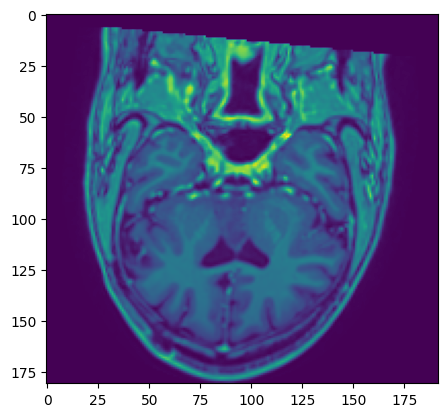

In [48]:
import matplotlib.pyplot as plt
plt.imshow(image_trim[:,90,:])

In [44]:
def bbox2(img):
    deps = np.any(img, axis=2)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    zmin, zmax = np.where(deps)[0][[0, -1]]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return img[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]

In [45]:
image_trim2 = bbox2(image)
image.shape, image_trim2.shape

((181, 246, 212), (181, 181, 202))

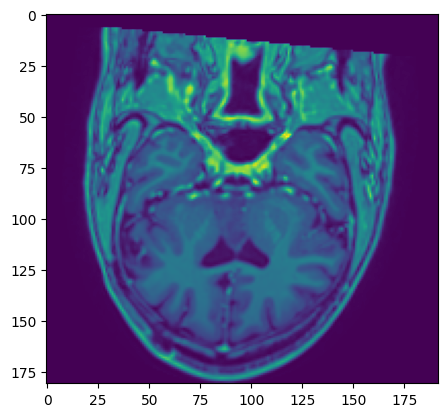

In [47]:
plt.imshow(image_trim[:,90,:])

array([  0, 180])

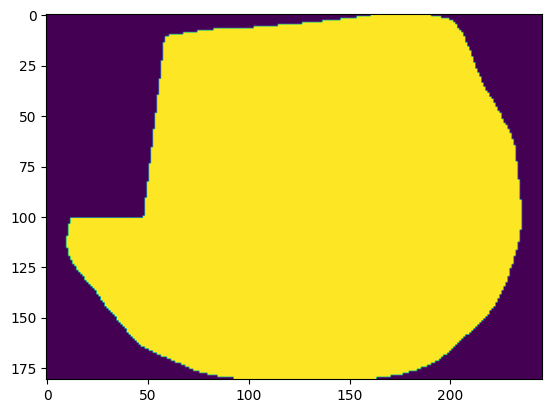

In [53]:
deps = np.any(image, axis=2)
plt.imshow(deps)
np.where(deps)[0][[0, -1]]

## Preprocess Script

In [82]:
import SimpleITK as sitk
import numpy as np
import os

DATA_PARENT_DIR = '../Task1/brain/'
dataset_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mr.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
mask_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mask.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
category = [dataset_dir[i].split('/')[-2][2] for i in range(len(dataset_dir))]
category_dir = {'A':[], 'B':[], 'C':[]}
for dir,cat in zip(zip(dataset_dir,mask_dir), category):
    if cat == 'A':
        category_dir['A'].append(dir)
    if cat == 'B':
        category_dir['B'].append(dir)
    if cat == 'C':
        category_dir['C'].append(dir)


threshold_dict = {'A':100, 'B':40, 'C':40}
NORMALIZATION_FACTOR = 350


def bbox(img):
    deps = np.any(img, axis=2)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    zmin, zmax = np.where(deps)[0][[0, -1]]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return img[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]

# for cat in ['A','B','C']:
for cat in ['B']:
    for mri_img_path, mask_path in category_dir[cat][:1]:
    # for mri_img_path, mask_path in category_dir[cat]:
        print(mri_img_path)

        # read MRI and its mask
        mri_img_sitk = sitk.ReadImage(mri_img_path)
        mri_img = sitk.GetArrayFromImage(mri_img_sitk)
        mask_original = sitk.ReadImage(mask_path)
        mask_original = sitk.GetArrayFromImage(mask_original).astype(bool)

        # create the threshold mask
        threshold = threshold_dict[cat]
        mask_threshold = np.zeros_like(mri_img, dtype=bool)
        mask_threshold[mri_img > threshold] = 1

        # apply the mask and create a 1-D array of intersting voxels
        mri_img_masked = mri_img[mask_original & mask_threshold]

        # calculate mean and standard deviation
        img_mean = np.mean(mri_img_masked)
        img_var = np.std(mri_img_masked)

        # zero out the voxel outside the original mask (filter out non-interesting values) and reduce the dimension using bounding box, and normalize the image
        normalized_img = np.where(~mask_original, 0, mri_img)
        normalized_img = bbox(normalized_img) 
        normalized_img = (normalized_img - img_mean) / img_var
        normalized_img += np.abs(np.min(normalized_img))
        normalized_img *= NORMALIZATION_FACTOR

        # convert back to SITK
        normalized_img_sitk = sitk.GetImageFromArray(normalized_img)
        # normalized_img_sitk.CopyInformation(mri_img_sitk)
        # normalized_img_sitk.SetOrigin(image_sitk.GetOrigin())
        normalized_img_sitk.SetSpacing((1.0, 1.0, 1.0))
        normalized_img_sitk.SetDirection(image_sitk.GetDirection())

        # save to nifti file
        output_path = mri_img_path[:-7] + '_normalized' + mri_img_path[-7:]
        sitk.WriteImage(normalized_img_sitk, output_path)

../Task1/brain/1BB033/mr.nii.gz


In [81]:
mri_img_sitk.GetSpacing()

(1.0, 1.0, 1.0)

In [137]:
import SimpleITK as sitk
import numpy as np
import os

DATA_PARENT_DIR = '../Task1/brain/'
dataset_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mr.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
mask_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mask.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
category = [dataset_dir[i].split('/')[-2][2] for i in range(len(dataset_dir))]
category_dir = {'A':[], 'B':[], 'C':[]}
for dir,cat in zip(zip(dataset_dir,mask_dir), category):
    if cat == 'A':
        category_dir['A'].append(dir)
    if cat == 'B':
        category_dir['B'].append(dir)
    if cat == 'C':
        category_dir['C'].append(dir)
SPACING = (1.0, 1.0, 1.0)

threshold_dict = {'A':100, 'B':40, 'C':40}
NORMALIZATION_FACTOR = 350


def bbox(img):
    deps = np.any(img, axis=2)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    zmin, zmax = np.where(deps)[0][[0, -1]]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return int(zmin),int(zmax), int(ymin),int(ymax), int(xmin),int(xmax)
    # return img[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]

# for cat in ['A','B','C']:
for cat in ['B']:
    for mri_img_path, mask_path in category_dir[cat][:1]:
    # for mri_img_path, mask_path in category_dir[cat]:
        print(mri_img_path)

        # read MRI and its mask
        mri_img_sitk = sitk.ReadImage(mri_img_path)
        mri_img = sitk.GetArrayFromImage(mri_img_sitk)
        mask_original = sitk.ReadImage(mask_path)
        mask_original = sitk.GetArrayFromImage(mask_original).astype(bool)

        # create the threshold mask
        threshold = threshold_dict[cat]
        mask_threshold = np.zeros_like(mri_img, dtype=bool)
        mask_threshold[mri_img > threshold] = 1

        # apply the mask and create a 1-D array of intersting voxels
        mri_img_masked = mri_img[mask_original & mask_threshold]

        # calculate mean and standard deviation
        img_mean = np.mean(mri_img_masked)
        img_var = np.std(mri_img_masked)

        # zero out the voxel outside the original mask (filter out non-interesting values) and reduce the dimension using bounding box, and normalize the image
        normalized_img = np.where(~mask_original, 0, mri_img)
        zmin,zmax, ymin,ymax, xmin,xmax = bbox(normalized_img)
        # normalized_img = normalized_img[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
        # normalized_img = bbox(normalized_img) 
        normalized_img = (normalized_img - img_mean) / img_var
        normalized_img += np.abs(np.min(normalized_img))
        normalized_img *= NORMALIZATION_FACTOR

        # convert back to SITK
        normalized_img_sitk = sitk.GetImageFromArray(normalized_img)
        # normalized_img_sitk.CopyInformation(mri_img_sitk)
        # initial_origin = np.array(mri_img_sitk.GetOrigin())
        # normalized_img_sitk.SetOrigin(initial_origin + np.array([xmin, ymin, zmin]) * np.array(SPACING))
        # normalized_img_sitk.SetOrigin(image_sitk.GetOrigin())
        normalized_img_sitk = sitk.Crop(normalized_img_sitk, (zmin,ymin,xmin), (zmax,ymax,xmax))
        normalized_img_sitk.SetSpacing(SPACING)
        normalized_img_sitk.SetDirection(image_sitk.GetDirection())

        # save to nifti file
        output_path = mri_img_path[:-7] + '_normalized' + mri_img_path[-7:]
        sitk.WriteImage(normalized_img_sitk, output_path)

../Task1/brain/1BB033/mr.nii.gz


In [91]:
initial_origin = np.array(mri_img_sitk.GetOrigin())
SPACING = (1.0, 1.0, 1.0)
zmin,zmax, ymin,ymax, xmin,xmax = bbox(normalized_img)
initial_origin, np.array([xmin, ymin, zmin]), np.array([xmax, ymax, zmax])

(array([-102.51171875, -360.51171875, -120.        ]),
 array([10,  0,  0]),
 array([180, 180, 180]))

In [88]:
mri_img.shape, normalized_img.shape

((181, 246, 212), (181, 181, 202))

In [126]:
# normalized_img_sitk = sitk.GetImageFromArray(normalized_img)
# sitk.RegionOfInterest(mri_img_sitk, (zmax - zmin + 1, ymax - ymin + 1, xmax - xmin + 1), (zmin,ymin,xmin))
# sitk.RegionOfInterest(normalized_img_sitk, (xmax,ymax,zmax), (xmin,ymin,zmin))
zmax,ymax,xmax,zmin,ymin,xmin = int(zmax),int(ymax),int(xmax),int(zmin),int(ymin),int(xmin)
# sitk.Crop(mri_img_sitk, (zmax,ymax,xmax), (zmin,ymin,xmin))
sitk.Crop(mri_img_sitk, (xmin,ymin,zmin), (xmax,ymax,zmax))
# sitk.Crop(mri_img_sitk, (0,0,0), np.array(mri_img.shape)-1)
# sitk.Crop(mri_img_sitk, (0,0,0), tuple([a-10 for a in mri_img.shape]))
# sitk.Crop(mri_img_sitk, (0,0,0), (100,100,100))

RuntimeError: Exception thrown in SimpleITK Crop: /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.4/itkCropImageFilter.hxx:73:
ITK ERROR: CropImageFilter(0x6290b50): The input image's size [212, 246, 181] is less than the total of the crop size!

In [132]:
zmax,ymax,xmax,zmin,ymin,xmin

(180, 180, 235, 0, 0, 10)

In [117]:
tuple([a-1 for a in mri_img.shape])

(180, 245, 211)

In [136]:
normalized_img.shape, mri_img.shape, (zmin,xmin,ymin), (zmax,xmax,ymax)

((181, 246, 212), (181, 246, 212), (0, 0, 10), (180, 235, 180))

again

In [139]:
# Find slices that are all zeros along each axis
# Axis 0 corresponds to the z-dimension (axial slices)
# Axis 1 corresponds to the y-dimension (coronal slices)
# Axis 2 corresponds to the x-dimension (sagittal slices)

def bbox3(image_array):
    non_zero_slices_z = np.any(image_array != 0, axis=(1, 2))
    image_array = image_array[non_zero_slices_z, :, :]
    
    # Remove all-zero slices along the y-axis (coronal view)
    non_zero_slices_y = np.any(image_array != 0, axis=(0, 2))
    image_array = image_array[:, non_zero_slices_y, :]
    
    # Remove all-zero slices along the x-axis (sagittal view)
    non_zero_slices_x = np.any(image_array != 0, axis=(0, 1))
    image_array = image_array[:, :, non_zero_slices_x]
    return image_array

In [146]:
import SimpleITK as sitk
import numpy as np
import os

DATA_PARENT_DIR = '../Task1/brain/'
dataset_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mr.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
mask_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mask.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
category = [dataset_dir[i].split('/')[-2][2] for i in range(len(dataset_dir))]
category_dir = {'A':[], 'B':[], 'C':[]}
for dir,cat in zip(zip(dataset_dir,mask_dir), category):
    if cat == 'A':
        category_dir['A'].append(dir)
    if cat == 'B':
        category_dir['B'].append(dir)
    if cat == 'C':
        category_dir['C'].append(dir)
SPACING = (1.0, 1.0, 1.0)

threshold_dict = {'A':100, 'B':40, 'C':40}
NORMALIZATION_FACTOR = 350

def bbox(image_array):
    non_zero_slices_z = np.any(image_array != 0, axis=(1, 2))
    image_array = image_array[non_zero_slices_z, :, :]
    
    non_zero_slices_y = np.any(image_array != 0, axis=(0, 2))
    image_array = image_array[:, non_zero_slices_y, :]
    
    non_zero_slices_x = np.any(image_array != 0, axis=(0, 1))
    image_array = image_array[:, :, non_zero_slices_x]
    return image_array

for cat in ['A','B','C']:
# for cat in ['B']:
    # for mri_img_path, mask_path in category_dir[cat][:1]:
    for mri_img_path, mask_path in category_dir[cat]:
        # read MRI and its mask
        mri_img_sitk = sitk.ReadImage(mri_img_path)
        mri_img = sitk.GetArrayFromImage(mri_img_sitk)
        mask_original = sitk.ReadImage(mask_path)
        mask_original = sitk.GetArrayFromImage(mask_original).astype(bool)

        # create the threshold mask
        threshold = threshold_dict[cat]
        mask_threshold = np.zeros_like(mri_img, dtype=bool)
        mask_threshold[mri_img > threshold] = 1

        # apply the mask and create a 1-D array of intersting voxels
        mri_img_masked = mri_img[mask_original & mask_threshold]

        # calculate mean and standard deviation
        img_mean = np.mean(mri_img_masked)
        img_var = np.std(mri_img_masked)

        # zero out the voxel outside the original mask (filter out non-interesting values) and reduce the dimension using bounding box, and normalize the image
        normalized_img = np.where(~mask_original, 0, mri_img)
        normalized_img = bbox(normalized_img)
        normalized_img = (normalized_img - img_mean) / img_var
        normalized_img += np.abs(np.min(normalized_img))
        normalized_img *= NORMALIZATION_FACTOR

        # convert back to SITK
        normalized_img_sitk = sitk.GetImageFromArray(normalized_img)
        normalized_img_sitk.SetOrigin(image_sitk.GetOrigin())
        normalized_img_sitk.SetSpacing(SPACING)
        normalized_img_sitk.SetDirection(image_sitk.GetDirection())

        print(mri_img_path, 'orig:', mri_img.shape, 'norm:', normalized_img.shape)

        # save to nifti file
        output_path = mri_img_path[:-7] + '_normalized' + mri_img_path[-7:]
        sitk.WriteImage(normalized_img_sitk, output_path)

../Task1/brain/1BA076/mr.nii.gz orig: (197, 247, 190) norm: (196, 226, 168)
../Task1/brain/1BA294/mr.nii.gz orig: (204, 242, 205) norm: (204, 223, 185)
../Task1/brain/1BA307/mr.nii.gz orig: (194, 238, 202) norm: (194, 218, 180)
../Task1/brain/1BA253/mr.nii.gz orig: (184, 235, 203) norm: (184, 214, 182)
../Task1/brain/1BA159/mr.nii.gz orig: (196, 259, 224) norm: (196, 231, 195)
../Task1/brain/1BA164/mr.nii.gz orig: (207, 259, 226) norm: (207, 234, 189)
../Task1/brain/1BA175/mr.nii.gz orig: (189, 252, 220) norm: (189, 233, 196)
../Task1/brain/1BA358/mr.nii.gz orig: (198, 246, 201) norm: (198, 226, 178)
../Task1/brain/1BA345/mr.nii.gz orig: (213, 235, 202) norm: (213, 215, 182)
../Task1/brain/1BA058/mr.nii.gz orig: (197, 267, 231) norm: (197, 248, 208)
../Task1/brain/1BA022/mr.nii.gz orig: (211, 267, 232) norm: (211, 237, 200)
../Task1/brain/1BA247/mr.nii.gz orig: (200, 227, 204) norm: (200, 208, 183)
../Task1/brain/1BA300/mr.nii.gz orig: (211, 239, 225) norm: (211, 220, 205)
../Task1/bra